# Tutorial: Quantum-Inspired Matrix Product States (MPS)

This notebook demonstrates how to use the Quantum-inspired MPS implementation for sequence modeling tasks.

## Table of Contents
1. Setup and Basic Usage
2. Quantum Embeddings
3. Training an MPS Model
4. Sampling and Generation
5. Advanced Features

In [1]:
import torch
import numpy as np
from main import MPS, QuantumEmbed
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Setup and Basic Usage

Let's start by creating a simple MPS model and exploring its basic properties.

In [2]:
# Initialize a small MPS model
mps = MPS(
    n=4,              # number of sites (sequence length)
    phy_dim=2,        # physical dimension
    bond_dim=8,       # bond dimension
    voc_size=6        # vocabulary size
)

# Print model structure
print("MPS Model Structure:")
print(f"Number of sites: {mps.n}")
print(f"Physical dimension: {mps.phy_dim}")
print(f"Bond dimension: {mps.bond_dim}")
print(f"Vocabulary size: {mps.emb.v}")

MPS Model Structure:
Number of sites: 4
Physical dimension: 2
Bond dimension: 8
Vocabulary size: 6


## 2. Quantum Embeddings

The `QuantumEmbed` class converts discrete tokens into quantum measurements. Let's explore how it works.

In [3]:
# Create a quantum embedding layer
quantum_embed = QuantumEmbed(dim=2, voc_size=6, n=4)

# Convert some tokens to quantum measurements
tokens = [0, 1, 2]
measurements = quantum_embed(tokens)

print("Quantum Measurements:")
print(f"Input tokens: {tokens}")
print(f"Measurement shape: {measurements.shape}")
print("\nFirst measurement operator:")
print(measurements[0].real)

Quantum Measurements:
Input tokens: [0, 1, 2]
Measurement shape: torch.Size([3, 2, 2])

First measurement operator:
tensor([[0.0448, 0.0029],
        [0.0029, 0.1205]], grad_fn=<SelectBackward0>)


## 3. Training an MPS Model

Now let's see how to train the MPS model on some example data.

Epoch [10/50], Loss: 7.0619
Epoch [20/50], Loss: 7.0084
Epoch [30/50], Loss: 6.9770
Epoch [40/50], Loss: 6.9615
Epoch [50/50], Loss: 6.9507


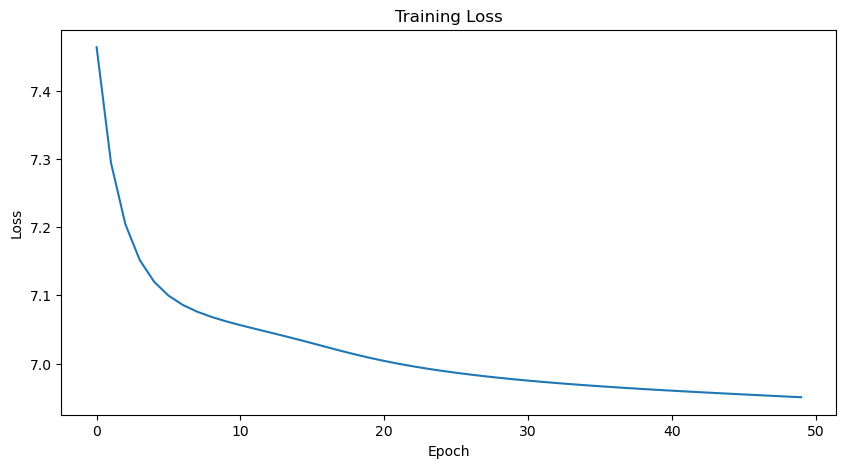

In [7]:
import torch.optim as optim
from main import iso_op

# Create synthetic training data
num_samples = 100
seq_length = 4
training_data = torch.randint(0, 6, (num_samples, seq_length))

# Initialize model and optimizer
model = MPS(n=seq_length, phy_dim=2, bond_dim=8, voc_size=6)
optimizer = optim.Adam([
    {'params': model.mps_blocks, 'name': 'iso'},
    {'params': model.emb.parameters(), 'name': 'emb'}
], lr=0.001)

# Training loop
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for sequence in training_data:
        optimizer.zero_grad()
        prob = model.prob(sequence.tolist())
        loss = -torch.log(prob.abs() + 1e-10)
        
        
        loss.backward()
        iso_op(optimizer, loss)
        optimizer.step()
        model.reset()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(training_data)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 4. Sampling and Generation

After training, we can use the model to generate new sequences.

In [8]:
# Generate multiple samples
num_samples = 5
generated_samples = []

for i in range(num_samples):
    sequence, prob = model.sample()
    generated_samples.append((sequence, prob.item()))
    print(f"Sample {i+1}: {sequence}, Probability: {prob.item():.4f}")

# Demonstrate step-by-step sampling
print("\nStep-by-step sampling:")
T = None
sequence = []
for site in range(model.n):
    token, T = model.sample_step(T, site)
    sequence.append(token)
    print(f"Step {site+1}: Generated token {token}")
print(f"Final sequence: {sequence}")

Sample 1: [4, 4, 1, 3], Probability: 0.0008
Sample 2: [3, 0, 2, 3], Probability: 0.0010
Sample 3: [0, 5, 0, 5], Probability: 0.0007
Sample 4: [4, 4, 5, 1], Probability: 0.0016
Sample 5: [1, 3, 0, 5], Probability: 0.0009

Step-by-step sampling:
Step 1: Generated token 4
Step 2: Generated token 5
Step 3: Generated token 0
Step 4: Generated token 4
Final sequence: [4, 5, 0, 4]


## 5. Advanced Features

Let's explore some advanced features of the MPS model.

In [12]:
# Examine the full tensor representation (warning: exponential complexity)
small_mps = MPS(n=3, phy_dim=3, bond_dim=4, voc_size=3)  # Using small n for demonstration
full_state = small_mps.full_tensor
print(f"Full state tensor shape: {full_state.shape}")

# Demonstrate one-hot embedding
quantum_embed = QuantumEmbed(dim=3, voc_size=3, n=4)
quantum_embed.reset(one_hot=True)
one_hot_measurements = quantum_embed([0, 1, 2])
print(f"\nOne-hot measurement shape: {one_hot_measurements.shape}")

# Show probability calculation for different sequence lengths
print("\nProbability calculations:")
sequences = [
    [0],
    [0, 1],
    [0, 1, 2]
]

for seq in sequences:
    prob = small_mps.prob(seq)
    print(f"Sequence {seq}: probability shape {prob.shape}")

Full state tensor shape: torch.Size([3, 3, 3])

One-hot measurement shape: torch.Size([3, 3, 3])

Probability calculations:
Sequence [0]: probability shape torch.Size([1, 3, 3, 1])
Sequence [0, 1]: probability shape torch.Size([1, 4, 4, 1])
Sequence [0, 1, 2]: probability shape torch.Size([1])


## Conclusion

This tutorial demonstrated the key features of the Quantum-inspired MPS implementation:
- Basic model setup and configuration
- Quantum embeddings for discrete tokens
- Training procedure with isometric constraints
- Sequence generation and sampling
- Advanced features and probability calculations

The MPS model provides an efficient way to represent and generate sequences while maintaining quantum-inspired properties through its tensor network structure.